# **Animations Presentation**

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from cartopy import crs, feature

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

rc('animation', html='html5')
from IPython.display import HTML, Video

## Functions

#### Path prefix

In [2]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

#### Scatter_Colors

In [3]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def scatter_particles(ax, N,colors, nmin, nmax,yvar):
    scatter=[]
    #N is the number of stations
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate
    
    starts = np.arange(0,N*n,n)
    ends = np.arange(n-1,N*n,n)
    if N < len(colors):
        colors = colors[0:N]
    elif N > len(colors):
        con = 0
        while N > len(colors):
            colors.append(colors[con])
            con+=1
    if nmin==nmax:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin], yvar[starts[i]:ends[i], nmin],c=colors[i],s=5))
    else:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin:nmax], yvar[starts[i]:ends[i], nmin:nmax],c=colors[i],s=5))
    return scatter

#### Useful Kernel

In [4]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

In [14]:
def Buoyancy(particle, fieldset, time):
    '''Stokes law settling velocity and critical sinking velocity'''
    Rp = 150 #Density particle: PE (~960 kg/m3 ),PS (~150 kg/m3), PET (~1370 kg/m3).
    ESD=5e-5 #Size particle (ESD) equivalent spherical diameter
    #visc=1e-3 #average viscosity sea water
     
    z = particle.depth
    u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    if  u == 0:
        dz = 0
    else:
        
        a = -0.15
        b = 0.78
        k=4.5e-3
        pa=10.13
        ro0 = 1027
        t0 = 10
        s0 = 35
        g = 9.8
        t = fieldset.T[time, particle.depth, particle.lat, particle.lon]
        s = fieldset.S[time, particle.depth, particle.lat, particle.lon]
        p = ((g*z*ro0)/1e4)+pa
        ro = ro0 + a*(t-t0) + b*(s-s0) + k*p
        visc = 4.2844e-5 + 1/(0.157*((t + 64.993)**2)-91.296)
        Ws= ((ESD**2)*g*(Rp-ro))/(18*visc)
        WWS =(11.68 + 0.1991*ESD*1e6 + 0.0004*(ESD*1e6)**2- 0.0993*(Rp-ro) + 0.0002*(Rp-ro)**2)/86400
        
    if Ws>WWS:
        dz = WWS*particle.dt
    else:
        dz = Ws*particle.dt
    if dz+z > 0:
        particle.depth += dz
    else:
        particle.depth = 0.5

## Load drifters and definitions

In [15]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/jvalenti/MOAD/grid/mesh_mask201702.nc',
    'out': '/home/jvalenti/MOAD/analysis-jose/notebooks/results',
    'anim': '/home/jvalenti/MOAD/animations'
}

In [16]:
# Duration and timestep [s]
length = 15
duration = timedelta(days=length)
dt = timedelta(minutes=2)

In [17]:
def zdep(dmin,dd):
    if isinstance(dmin,int):
        zvals1 = dmin + np.random.random_sample([n,N]).T*(dd)
    else:
        zvals = []
        zvals1 = []
        for dept in dmin:
            zvals.append(dept + np.random.random_sample([n]).T*(dd))
        for i in range(len(zvals)):   
            zvals1=np.concatenate((zvals1[:],zvals[i]))
    return zvals1   

In [18]:
N = 6 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 1000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = [0,0,0,0,0,70]
dd = 20
zvals = zdep(dmin,dd)

## Simulation

In [19]:
start = datetime(2018, 1, 17)
daterange = [start+timedelta(days=i) for i in range(length)]
# Build filenames
Ulist, Vlist, Wlist = [], [], []
Tlist= []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')
    Tlist.append(path_NEMO + '_grid_T.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
    'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
    'T': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist},
    'S': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz','T':'votemper','S':'vosaline'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

#bring salish sea results into field_set
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

/results2/SalishSea/nowcast-green.201905/17jan18/SalishSea_1h_20180117_20180117
/results2/SalishSea/nowcast-green.201905/18jan18/SalishSea_1h_20180118_20180118
/results2/SalishSea/nowcast-green.201905/19jan18/SalishSea_1h_20180119_20180119
/results2/SalishSea/nowcast-green.201905/20jan18/SalishSea_1h_20180120_20180120
/results2/SalishSea/nowcast-green.201905/21jan18/SalishSea_1h_20180121_20180121
/results2/SalishSea/nowcast-green.201905/22jan18/SalishSea_1h_20180122_20180122
/results2/SalishSea/nowcast-green.201905/23jan18/SalishSea_1h_20180123_20180123
/results2/SalishSea/nowcast-green.201905/24jan18/SalishSea_1h_20180124_20180124
/results2/SalishSea/nowcast-green.201905/25jan18/SalishSea_1h_20180125_20180125
/results2/SalishSea/nowcast-green.201905/26jan18/SalishSea_1h_20180126_20180126
/results2/SalishSea/nowcast-green.201905/27jan18/SalishSea_1h_20180127_20180127
/results2/SalishSea/nowcast-green.201905/28jan18/SalishSea_1h_20180128_20180128
/results2/SalishSea/nowcast-green.201905

### Change name for each run!!

In [20]:
# Set output file name.  Maybe change for each run
fn = f'PS2' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/home/jvalenti/MOAD/analysis-jose/notebooks/results/PS220180117_1n_20180201_1n.nc


In [21]:
Dat=xr.open_dataset('/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]

### Set particle location

In [22]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,float(outf_lon)], [49.186308,49.975326,49.305448,47.622403,48.399420,float(outf_lat)]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [23]:
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))

p_flt = pset.Kernel(Buoyancy) 

pset.execute(AdvectionRK4_3D + p_flt, 
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvectionRK4_3DBuoyancy ==> /tmp/parcels-2894/lib81532dea4cd5a80ae3cc4a6dade0344e_0.so
INFO: Temporary output files are stored in /home/jvalenti/MOAD/analysis-jose/notebooks/results/out-TFHEEWZP.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jvalenti/MOAD/analysis-jose/notebooks/results/out-TFHEEWZP" to convert these to a NetCDF file during the run.
 12% (163800.0 of 1296000.0) |#          | Elapsed Time: 0:01:40 ETA:   0:21:46

Particle 378 lost !! [-122.48853593342062, 47.93574034397734, 1.4645323307277414e-06, 169440.0]


 14% (181800.0 of 1296000.0) |#          | Elapsed Time: 0:01:54 ETA:   0:25:02

Particle 442 lost !! [-123.44092820560724, 48.418343703060025, 1.5481975934594772e-07, 187800.0]
Particle 455 lost !! [-123.44128076976348, 48.41835569386902, 1.5481975934594772e-07, 187800.0]
Particle 468 lost !! [-123.44122847437083, 48.41835727900539, 1.5481975934594772e-07, 187800.0]


 24% (311400.0 of 1296000.0) |##         | Elapsed Time: 0:03:34 ETA:   0:25:09

Particle 142 lost !! [-125.01937624280403, 50.161257683963754, 8.971661701190348e-07, 318120.0]


 33% (430200.0 of 1296000.0) |###        | Elapsed Time: 0:05:16 ETA:   0:24:19

Particle 164 lost !! [-125.15274959987838, 50.048731923667, 2.502247911706501e-06, 435600.0]
Particle 169 lost !! [-125.15267000728932, 50.04860374936292, 2.502247911706501e-06, 435600.0]


 38% (504000.0 of 1296000.0) |####       | Elapsed Time: 0:06:15 ETA:   0:10:30

Particle 478 lost !! [-123.22855708386729, 48.310261748884805, 8.854931287383128e-07, 510480.0]


 40% (531000.0 of 1296000.0) |####       | Elapsed Time: 0:06:51 ETA:   0:35:05

Particle 138 lost !! [-125.14991887518595, 50.078154023290445, 2.2589314342957856e-06, 537600.0]


 55% (718200.0 of 1296000.0) |######     | Elapsed Time: 0:11:39 ETA:   0:25:26

Particle 21 lost !! [-124.9156189412296, 50.00361703245908, 2.119315581139425e-06, 723840.0]


 62% (815400.0 of 1296000.0) |######     | Elapsed Time: 0:13:45 ETA:   0:12:38

Particle 180 lost !! [-125.0122118992892, 49.87033107426446, 4.6140811216233146e-07, 821280.0]


 66% (858600.0 of 1296000.0) |#######    | Elapsed Time: 0:14:27 ETA:   0:18:36

Particle 264 lost !! [-123.43755662736609, 49.2234101055375, 4.7669921897364187e-07, 865440.0]


 66% (867600.0 of 1296000.0) |#######    | Elapsed Time: 0:14:38 ETA:   0:10:23

Particle 61 lost !! [-125.06068258631682, 49.85590624284296, 2.3765834070710312e-06, 874560.0]


 69% (903600.0 of 1296000.0) |#######    | Elapsed Time: 0:15:24 ETA:   0:06:12

Particle 314 lost !! [-123.14091616116895, 48.24985871809096, 1.4677050025752036e-06, 910320.0]


 74% (963000.0 of 1296000.0) |########   | Elapsed Time: 0:16:34 ETA:   0:16:27

Particle 571 lost !! [-124.63734276785118, 49.77048914804721, 7.409298425214983e-07, 968760.0]


 74% (966600.0 of 1296000.0) |########   | Elapsed Time: 0:16:37 ETA:   0:09:14

Particle 521 lost !! [-124.26448264006008, 49.54544330503082, 8.761969113452173e-07, 972120.0]


 88% (1141200.0 of 1296000.0) |########  | Elapsed Time: 0:19:30 ETA:   0:02:36

Particle 499 lost !! [-124.77823843322957, 48.49714148269217, 0.5, 1147920.0]


 90% (1175400.0 of 1296000.0) |######### | Elapsed Time: 0:20:01 ETA:   0:03:20

Particle 388 lost !! [-123.12498845945873, 48.2783740554987, 1.7075773578456577e-07, 1180800.0]


 91% (1182600.0 of 1296000.0) |######### | Elapsed Time: 0:20:08 ETA:   0:03:12

Particle 431 lost !! [-124.93861145107361, 48.68794533845018, 0.07769915991629948, 1189320.0]


 93% (1211400.0 of 1296000.0) |######### | Elapsed Time: 0:20:33 ETA:   0:01:56

Particle 483 lost !! [-124.89850551201768, 48.64029945376119, 0.07669674083004412, 1217400.0]


 93% (1213200.0 of 1296000.0) |######### | Elapsed Time: 0:20:33 ETA:   0:01:09

Particle 453 lost !! [-124.73479148912953, 48.44533636414604, 0.5, 1218600.0]


 97% (1258200.0 of 1296000.0) |######### | Elapsed Time: 0:21:10 ETA:   0:00:51

Particle 409 lost !! [-123.5823594755372, 48.252825052052096, 2.3670889268134765e-07, 1264200.0]


100% (1296000.0 of 1296000.0) |##########| Elapsed Time: 0:21:30 Time:  0:21:30
/home/jvalenti/conda_envs/parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [24]:
# Set output file name.  Maybe change for each run
fn = f'PS2' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/home/jvalenti/MOAD/analysis-jose/notebooks/results/PS220180117_1n_20180201_1n.nc


In [25]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

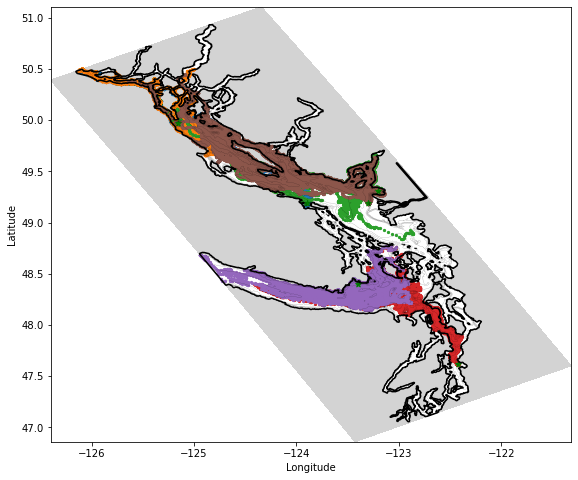

In [26]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/1)
nmin, nmax = 0, -1
#ax.scatter(ds.lon[:, nmax], ds.lat[:, nmax],c='b',s=2)
scatter_particles(ax, N,colors, nmin, nmax, ds.lat)
ax.scatter(clon,clat,c='g', marker='*', linewidths=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

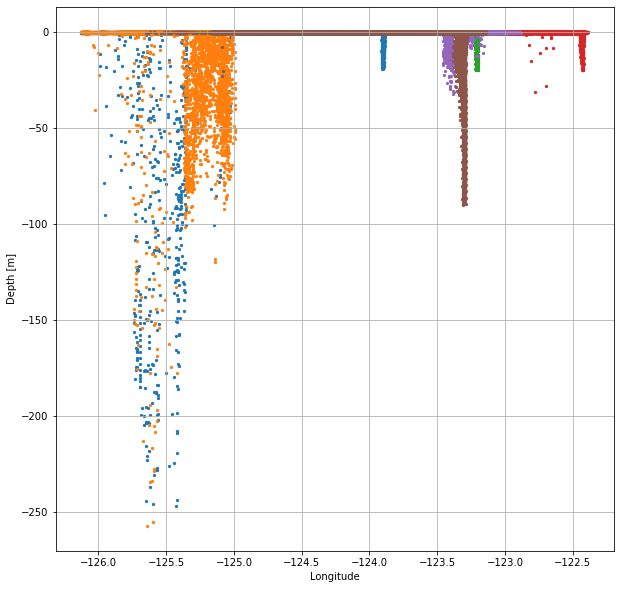

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_particles(ax, N,colors, nmin, nmax, -ds.z)
ax.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

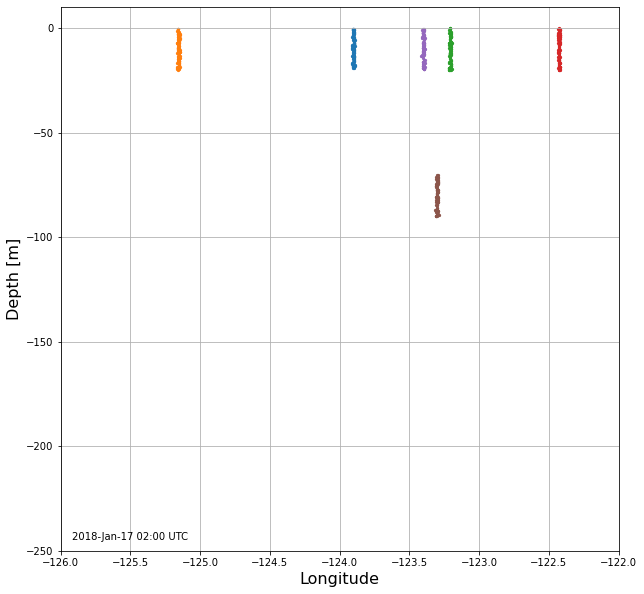

In [28]:
fps = 30
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(-126,-122),ylim=(-250,10))
#Include time in animation
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
t.set_text('')
ss = scatter_particles(ax, N,colors, 0, 0, -ds.z)
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.grid()

def update(hour):
    tstamp = ds.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, hour, hour, -ds.z)
    return ss

anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps),repeat=True)
anim
#f = r"/Users/jvalenti/MOAD/animations/depth_storm.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)

In [21]:
###load YT
#ID_yt = "CGlbGgVnbos"
#YouTubeVideo(ID_yt)
###
#Video("/Users/jvalenti/MOAD/analysis-jose/notebooks/results/anim.mp4",embed=True) 

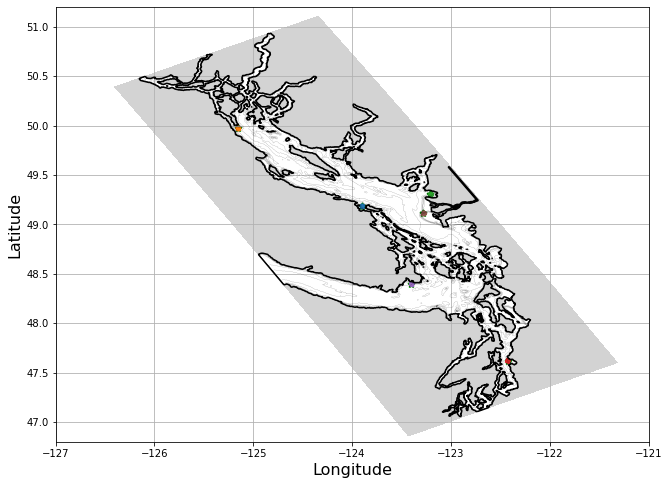

In [16]:
fps = 1
fig = plt.figure(figsize=(19, 8))
ax = plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))

#Include time in animation
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
t.set_text('')

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.grid()
ax.set_aspect(1/1)
ax.scatter(clon,clat,c='g', marker='*', linewidths=2)
plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
ss = scatter_particles(ax, N,colors, 0,0, ds.lat)

def update(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, frames,frames, ds.lat)
    return ss


anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))
anim
#f = r"/Users/jvalenti/MOAD/animations/storm.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)

In [29]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def scatterHD_particles(ax, N,colors, nmin, nmax,yvar):
    scatter=[]
    #N is the number of stations
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate
    
    starts = np.arange(0,N*n,n)
    ends = np.arange(n-1,N*n,n)
    if N < len(colors):
        colors = colors[0:N]
    elif N > len(colors):
        con = 0
        while N > len(colors):
            colors.append(colors[con])
            con+=1
    if nmin==nmax:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin], yvar[starts[i]:ends[i], nmin],c=colors[i],s=5,transform=crs.PlateCarree(),zorder=2))
    else:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin:nmax], yvar[starts[i]:ends[i], nmin:nmax],c=colors[i],s=5,transform=crs.PlateCarree(),zorder=2))
    return scatter

<Figure size 1368x576 with 0 Axes>

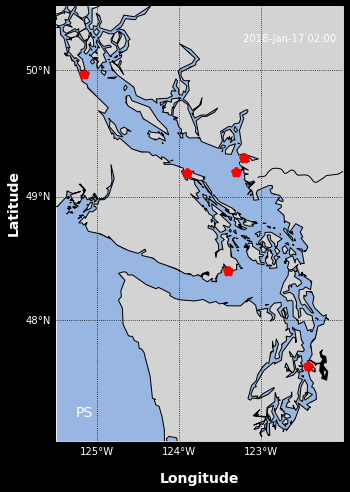

In [31]:
fps = 2
fig = plt.figure(figsize=(19, 8))

# Make map
fig, ax = plt.subplots(figsize=(19, 8), subplot_kw={'projection': crs.Mercator()})

#Include time in animation
t = ax.text(0.65, 0.92, '', transform=ax.transAxes,zorder=5)
t.set_text('')

ax.set_extent([-125.5, -122, 47, 50.5], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='lightgray'),zorder=3)
ax.add_feature(feature.RIVERS, edgecolor='k',zorder=5)
ax.add_feature(feature.OCEAN,zorder=1)

gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-126, -121), ylocs=range(47, 52),zorder=5)
gl.top_labels, gl.right_labels = False, False
ss=scatterHD_particles(ax, N,colors, 0, 0,ds.lat)
ax.scatter(clon,clat,c='r', marker='*', linewidth=5,transform=crs.PlateCarree(),zorder=4)
ax.text(-0.12, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")

ax.text(0.1, 0.05, 'PS', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)

plt.style.use('dark_background')

def animate(frames):
    tstamp = ds.time[0, frames].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M'))
    global ss
    for scat in ss:
        scat.remove()
    ss=scatterHD_particles(ax, N,colors, frames, frames,ds.lat)


anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(ds.lon[0,:]),fps))
f = r"/home/jvalenti/MOAD/animations/PS.mp4" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)